## Category: Getting Started

### Task 1: Import Modules and Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
import numpy as np
import nltk
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from collections import defaultdict
from sklearn.model_selection import train_test_split
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# downloading text processing libraries
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Category: Loading Data

### Task 2: Load and Explore the Genes and Variations Dataset

In [2]:
data = pd.read_csv('/usercode/training_variants')
print('Total number of data points: ', data.shape[0])
print('Total number of features: ', data.shape[1])
print('List of features: ', data.columns.values)
print ('The first five data points are:')
print (data.head())
print (data.dtypes)
print('Number of unique variations:', len(data['Variation'].unique()))
print ('Number of unique genes:', len(data['Gene'].unique()))

Total number of data points:  3321
Total number of features:  4
List of features:  ['ID' 'Gene' 'Variation' 'Class']
The first five data points are:
   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4
ID            int64
Gene         object
Variation    object
Class         int64
dtype: object
Number of unique variations: 2996
Number of unique genes: 264


In [3]:
data.head(20)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


### Task 3: Load the Text Dataset

In [4]:
text_data = pd.read_csv("/usercode/training_text",sep="\|\|",names=["ID","Text"],skiprows=1)
print('Number of data points: ', text_data.shape[0])
print('Number of features: ', text_data.shape[1])
print('Features: ', text_data.columns.values)
print(text_data.head())

/tmp/ipykernel_149/2415467616.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  text_data = pd.read_csv("/usercode/training_text",sep="\|\|",names=["ID","Text"],skiprows=1)


Number of data points:  3321
Number of features:  2
Features:  ['ID' 'Text']
   ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


In [5]:
text_data.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## Category: Text Pre-processing

### Task 4: Define the Function for Pre-processing

In [6]:
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    if isinstance(text, str):
        # Replace special characters with space
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        # Replace multiple spaces with a single space
        text = re.sub('\s+',' ', text)
        # Convert all the chars into lower-case
        text = text.lower()

        # Tokenize the sentence into a list of words
        words = word_tokenize(text)

        # Remove stop words. stopwords set defined using NLTK
        final_words = [word for word in words if word not in stop_words]

        # Join the filtered words back into a string
        final_text = ' '.join(final_words)

        return final_text

In [7]:
print("hello world")

hello world


### Task 5: Pre-process the Data

In [8]:
for idx, data_point in text_data.iterrows():
    if isinstance(data_point['Text'], str):
        text_data['Text'][idx] = text_preprocessing(data_point['Text'])
    else:
        print("Corresponding text data missing for data point number:", idx)

/tmp/ipykernel_149/1240470297.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['Text'][idx] = text_preprocessing(data_point['Text'])


Corresponding text data missing for data point number: 1109
Corresponding text data missing for data point number: 1277
Corresponding text data missing for data point number: 1407
Corresponding text data missing for data point number: 1639
Corresponding text data missing for data point number: 2755


In [9]:
text_data.head()

,ID,Text
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


### Task 6: Merge Datasets, Clean, and Impute Values

In [10]:
final_df = pd.merge(data, text_data, on='ID', how='left')
final_df['Text'] = final_df['Text'].fillna(final_df['Gene'] + ' ' + final_df['Variation'])

In [11]:
# Replace spaces with underscores in 'Gene' and 'Variation' columns
final_df['Gene'] = final_df['Gene'].str.replace('\s+', '_')
final_df['Variation'] = final_df['Variation'].str.replace('\s+', '_')

/tmp/ipykernel_149/1776589426.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  final_df['Gene'] = final_df['Gene'].str.replace('\s+', '_')
/tmp/ipykernel_149/1776589426.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  final_df['Variation'] = final_df['Variation'].str.replace('\s+', '_')


In [12]:
final_df.head(20)

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...
5,5,CBL,V391I,4,oncogenic mutations monomeric casitas b lineag...
6,6,CBL,V430M,5,oncogenic mutations monomeric casitas b lineag...
7,7,CBL,Deletion,1,cbl negative regulator activated receptor tyro...
8,8,CBL,Y371H,4,abstract juvenile myelomonocytic leukemia jmml...
9,9,CBL,C384R,4,abstract juvenile myelomonocytic leukemia jmml...


## Category: Train-test Split

### Task 7: Perform Train-test Split

In [13]:
     

# Split the data into test and train sets while maintaining the same distribution of the 'Class' column
init_train_df, test_df = train_test_split(final_df, test_size=0.2, stratify=final_df['Class'])

# Split the train data into train and cross-validation sets while maintaining the same distribution of the 'Class' column
train_df, cv_df = train_test_split(init_train_df, test_size=0.2, stratify=init_train_df['Class'])

# Extract the target variables
y_train = train_df['Class'].values
y_cv = cv_df['Class'].values
y_test = test_df['Class'].values

# Drop the 'Class' column from the datasets
x_train = train_df.drop(columns=['Class'])
x_cv = cv_df.drop(columns=['Class'])
x_test = test_df.drop(columns=['Class'])

In [14]:
x_train.head()

,ID,Gene,Variation,Text
2221,2221,PTEN,G129E,tumour suppressor gene pten maps 10q23 3 encod...
2660,2660,BRCA1,E1250K,mutations brca1 brca2 account majority heredit...
2147,2147,PTCH1,R571W,abstract hedgehog hh signaling largely suppres...
1965,1965,CTNNB1,S33F,screened 75 primary hepatocellular carcinomas ...
2492,2492,BRCA1,A1708E,abstract brca1 gene individuals risk breast ov...


In [15]:
x_cv.head()

,ID,Gene,Variation,Text
1019,1019,TSC2,H597Y,tuberous sclerosis complex tsc autosomal domin...
84,84,RIT1,A77T,abstract rasopathies autosomal dominant disord...
2346,2346,JAK2,R683G,children syndrome greatly increased risk acute...
1086,1086,EZH2,A677G,trimethylation histone h3 lysine 27 h3k27me3 r...
930,930,PDGFRA,F808L,activating mutations platelet derived growth f...


In [16]:
x_test.head()

,ID,Gene,Variation,Text
761,761,ERBB2,G309E,assessed somatic alleles six receptor tyrosine...
742,742,ERBB2,H878Y,overexpression erbb2 kinase observed one third...
2684,2684,BRAF,A598T,mutational hotspots indicate selective pressur...
137,137,LATS2,Deletion,malignant mesothelioma mm aggressive neoplasm ...
2793,2793,BRCA2,C1265S,abstract classification rare missense variants...


In [17]:
y_train

array([4, 5, 5, ..., 4, 4, 4])

### Task 8: Check Distribution of Dataset

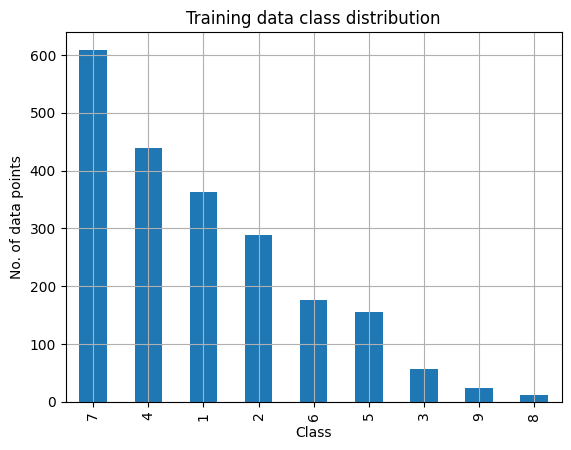

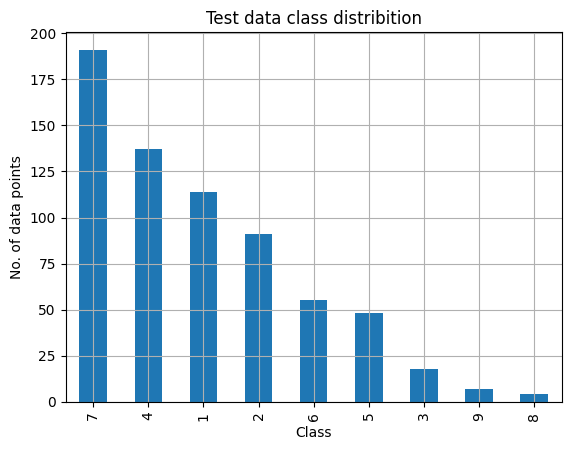

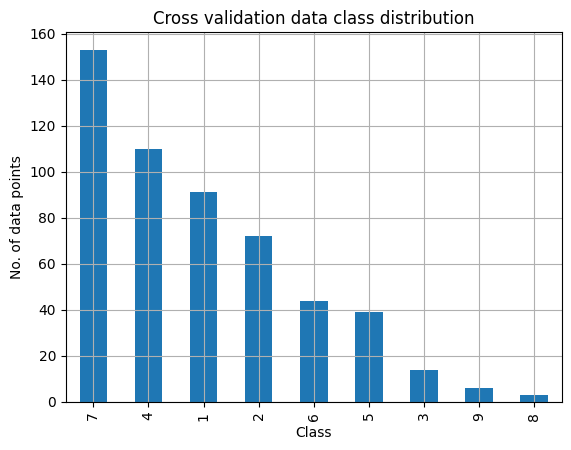

In [18]:
def plot_distribution(data_distribution, title):
    data_distribution.plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('No. of data points')
    plt.title(title)
    plt.grid()
    plt.show()


train_class_distribution = train_df['Class'].value_counts()
test_class_distribution = test_df['Class'].value_counts()
cv_class_distribution = cv_df['Class'].value_counts()

plot_distribution(train_class_distribution, 'Training data class distribution')
plot_distribution(test_class_distribution, 'Test data class distribition')
plot_distribution(cv_class_distribution, 'Cross validation data class distribution')

## Category: Measure Performance Using Random Model

### Task 9: Define a Function to Plot Performance Matrices

In [19]:
def plot_heatmap(matrix, labels, title):
    plt.figure()
    sns.heatmap(matrix, annot=True, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title(title)
    plt.show()


def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]

    # Calculate the recall matrix
    recall_matrix = C / C.sum(axis=1, keepdims=True)

    # Calculate the precision matrix
    precision_matrix = C / C.sum(axis=0, keepdims=True)

    # Plot the confusion matrix
    plot_heatmap(C, labels, "Confusion matrix")

    # Plot the precision matrix
    plot_heatmap(precision_matrix, labels, "Precision matrix (sum of elements in a column=1)")

    # Plot the recall matrix
    plot_heatmap(recall_matrix, labels, "Recall matrix (sum of elements in a row=1)")




### Task 10: Measure Metrics from a Dummy Baseline Model

Log loss on Cross Validation Data using Random Model: 2.4765412335498276
Log loss on Test Data using Random Model: 2.5819977926341933
Performance matrices for test data


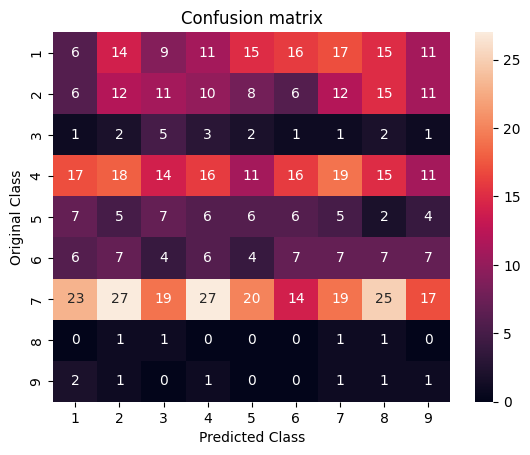

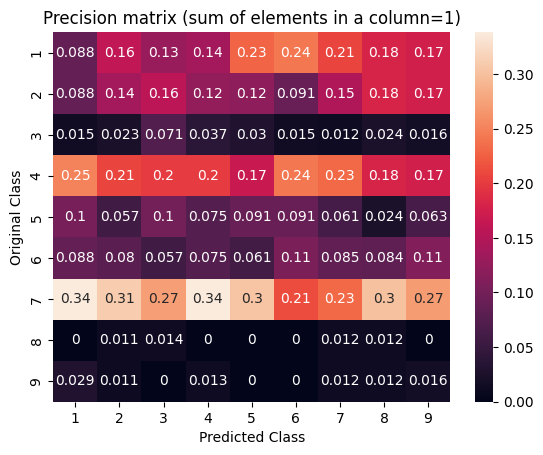

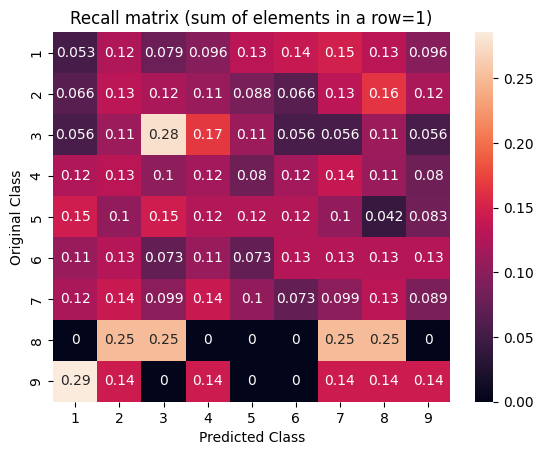

In [20]:
def generate_random_predictions(data_len):
    predicted_y = np.zeros((data_len, 9))
    for i in range(data_len):
        rand_probs = np.random.rand(1, 9)
        predicted_y[i] = rand_probs / rand_probs.sum()
    return predicted_y

cv_data_len = cv_df.shape[0]
test_data_len = test_df.shape[0]

# Generate random predictions for CV data
cv_predicted_y = generate_random_predictions(cv_data_len)
print("Log loss on Cross Validation Data using Random Model:", log_loss(y_cv, cv_predicted_y))

# Generate random predictions for test data
test_predicted_y = generate_random_predictions(test_data_len)
print("Log loss on Test Data using Random Model:", log_loss(y_test, test_predicted_y))

# Plot performance matrix for test data
predicted_y = np.argmax(test_predicted_y, axis=1)
print ("Performance matrices for test data")
plot_confusion_matrix(y_test, predicted_y + 1)

## Category: Encode the Features

### Task 11: Define the Functions for Response Coding

In [21]:
def extract_response_coding_probs(alpha, feature, df):
    total_classes = 9
    # Group the DataFrame by the feature and Class cloumns and get counts
    grouped = df.groupby([feature, 'Class']).size().reset_index(name='count')

    grouped.head()

    response_code_probs = {}
    feature_counts = df[feature].value_counts().to_dict()

    for value in feature_counts:
        value_group = grouped[grouped[feature] == value]
        class_probs = []
        for k in range(1, total_classes + 1):
            # Check if the current class exists for the current feature value
            if k in value_group['Class'].values:
                count = value_group[value_group['Class'] == k]['count'].values[0]
            else:
                count = 0

            numerator = count + alpha
            denominator = feature_counts[value] + total_classes * alpha
            class_probs.append(numerator / denominator)
        response_code_probs[value] = class_probs

    return response_code_probs

In [22]:
def generate_response_coded_feature(feature, df, response_code_probs):
    total_classes = 9
    default_prob = [1 / total_classes] * total_classes

    # Use the map() method to map the values of the feature column to the corresponding probabilities.
    # The get() method on the response_code_probs dictionary allows you to specify the default_prob as a fallback.
    response_coded_feature = df[feature].map(lambda x: response_code_probs.get(x, default_prob))

    return response_coded_feature.tolist()

### Task 12: Run the Function on 'Gene' and 'Variation' Features

In [23]:
alpha = 1

gene_dict = extract_response_coding_probs(alpha, 'Gene', train_df)

# Train the Gene feature
train_gene_rc = np.array(generate_response_coded_feature("Gene", train_df, gene_dict))
# Test the Gene feature
test_gene_rc = np.array(generate_response_coded_feature("Gene", test_df, gene_dict))
# Cross validate the Gene feature
cv_gene_rc = np.array(generate_response_coded_feature("Gene", cv_df, gene_dict))

variation_dict=extract_response_coding_probs(alpha, 'Variation', train_df)

# Train the Variation feature
train_variation_rc = np.array(generate_response_coded_feature("Variation", train_df, variation_dict))
# Test the Variation feature
test_variation_rc = np.array(generate_response_coded_feature("Variation", test_df, variation_dict))
# Cross validate the Variation feature
cv_variation_rc = np.array(generate_response_coded_feature("Variation", cv_df, variation_dict))

In [24]:
train_gene_rc

array([[0.01111111, 0.01111111, 0.05555556, ..., 0.01111111, 0.01111111,
        0.01111111],
       [0.25730994, 0.00584795, 0.08187135, ..., 0.00584795, 0.00584795,
        0.00584795],
       [0.18181818, 0.09090909, 0.09090909, ..., 0.09090909, 0.09090909,
        0.09090909],
       ...,
       [0.10526316, 0.05263158, 0.05263158, ..., 0.05263158, 0.05263158,
        0.05263158],
       [0.35      , 0.025     , 0.025     , ..., 0.05      , 0.025     ,
        0.025     ],
       [0.01111111, 0.01111111, 0.05555556, ..., 0.01111111, 0.01111111,
        0.01111111]])

In [25]:
train_variation_rc

array([[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]])

### Task 13: Count Words in Text Field

In [26]:
def extract_counter(cls_text):
    # Use the apply() method to split each row's 'TEXT' into a list of words and then concatenate those lists
    all_words = cls_text['Text'].apply(lambda x: x.split()).explode().tolist()
 
    # Use the Counter() method to count the occurrences of each word
    word_count = Counter(all_words)
 
    return word_count

In [27]:
dict_list = []
# dict_list is a list containing 9 dictionaries, each corresponding to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_counter(cls_text))

# total_dict is built on the entire training text data
total_dict = extract_counter(train_df)

In [28]:
len(dict_list)

9

In [29]:
total_dict

Counter({'tumour': 6155,
         'suppressor': 6080,
         'gene': 38998,
         'pten': 21256,
         'maps': 590,
         '10q23': 93,
         '3': 87370,
         'encodes': 1654,
         '403': 157,
         'amino': 18031,
         'acid': 12941,
         'dual': 1471,
         'specificity': 3796,
         'phosphatase': 6035,
         'protein': 54320,
         'tyrosine': 12704,
         'ptpase': 36,
         'shown': 28164,
         'recently': 6601,
         'play': 2628,
         'broad': 1480,
         'role': 13282,
         'human': 24705,
         'malignancy': 907,
         'somatic': 9803,
         'deletions': 5899,
         'mutations': 152413,
         'observed': 21500,
         'sporadic': 2837,
         'breast': 14524,
         'brain': 2666,
         'prostate': 4462,
         'kidney': 1208,
         'cancer': 63852,
         'cell': 81674,
         'lines': 22036,
         'several': 12574,
         'primary': 12310,
         'tumours': 4575,
    

In [30]:
print("Hello world")

Hello world


### Task 14: Define a Function for Response Coding

In [31]:
def generate_text_responsecoding(df, dict_list, total_dict, alpha):
    num_classes = 9  # Number of classes
    num_rows = df.shape[0]  # Number of rows in the DataFrame

    # Initialize a zeros array with shape (num_rows, num_classes)
    text_feature_rc = np.zeros((num_rows, num_classes))

    # Split the Text column into lists of words
    df['split_text'] = df['Text'].apply(lambda x: x.split())

    # Calculate response coding for each class
    for i in range(num_classes):
        row_index = 0
        for split_text in df['split_text']:
            # Use list comprehension and the map() method to apply the log probability calculations
            sum_prob = sum(
                map(
                    lambda word: math.log((dict_list[i].get(word, 0) + alpha) / (total_dict.get(word, 0) + 9*alpha)),
                    split_text
                )
            )
            # Calculate the final value for each row and class
            text_feature_rc[row_index, i] = math.exp(sum_prob / len(split_text))
            row_index += 1
 
            df.drop(['split_text'], axis=1)
           
    return text_feature_rc

### Task 15: Run the Function on Text Field

In [32]:
alpha = 10

train_text_rc  = generate_text_responsecoding(train_df, dict_list, total_dict, alpha)
test_text_rc  = generate_text_responsecoding(test_df, dict_list, total_dict, alpha)
cv_text_rc  = generate_text_responsecoding(cv_df, dict_list, total_dict, alpha)

In [33]:
train_df.head()

,ID,Gene,Variation,Class,Text,split_text
2221,2221,PTEN,G129E,4,tumour suppressor gene pten maps 10q23 3 encod...,"[tumour, suppressor, gene, pten, maps, 10q23, ..."
2660,2660,BRCA1,E1250K,5,mutations brca1 brca2 account majority heredit...,"[mutations, brca1, brca2, account, majority, h..."
2147,2147,PTCH1,R571W,5,abstract hedgehog hh signaling largely suppres...,"[abstract, hedgehog, hh, signaling, largely, s..."
1965,1965,CTNNB1,S33F,2,screened 75 primary hepatocellular carcinomas ...,"[screened, 75, primary, hepatocellular, carcin..."
2492,2492,BRCA1,A1708E,4,abstract brca1 gene individuals risk breast ov...,"[abstract, brca1, gene, individuals, risk, bre..."


### Task 16: One-hot Encode the Features

In [34]:
#One-hot encoding the Gene feature 
gene_vectorizer = CountVectorizer()
train_gene_oh = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_oh = gene_vectorizer.transform(test_df['Gene'])
cv_gene_oh = gene_vectorizer.transform(cv_df['Gene'])

feature_names = gene_vectorizer.get_feature_names_out()
len(feature_names)


225

In [35]:
#One-hot encoding the Variation feature
variation_vectorizer = CountVectorizer()
train_variation_oh = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_oh = variation_vectorizer.transform(test_df['Variation'])
cv_variation_oh = variation_vectorizer.transform(cv_df['Variation'])

feature_names_variation = variation_vectorizer.get_feature_names_out()
len(feature_names_variation)

1961

In [36]:
#One-hot encoding the Text feauture
text_vectorizer = CountVectorizer(min_df=3)
train_text_oh = text_vectorizer.fit_transform(train_df['Text'])
test_text_oh = text_vectorizer.transform(test_df['Text'])
cv_text_oh = text_vectorizer.transform(cv_df['Text'])

feature_names_text = text_vectorizer.get_feature_names_out()
len(feature_names_text)

53845

### Task 17: Normalizing the Text Feature

In [37]:
train_text_oh = normalize(train_text_oh, axis=0)
test_text_oh = normalize(test_text_oh, axis=0)
cv_text_oh = normalize(cv_text_oh, axis=0)

train_text_rc = normalize(train_text_rc, axis=1, norm='l1')
test_text_rc = normalize(test_text_rc, axis=1, norm='l1')
cv_text_rc = normalize(cv_text_rc, axis=1, norm='l1')


## Category: Check Feature Importances

### Task 18: Train Single Feature Models

In [38]:
gene_log_error_array = []
alpha = 0.001

clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_oh, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(cv_gene_oh, y_cv)
predict_array = sig_clf.predict_proba(cv_gene_oh)
gene_log_error = log_loss(y_cv, predict_array, labels=clf.classes_, eps=1e-15)
print (gene_log_error)

1.232271626701443


In [39]:
variation_log_error_array = []
alpha = 0.001

clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_oh, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(cv_variation_oh, y_cv)
predict_array = sig_clf.predict_proba(cv_variation_oh)
variation_log_error=log_loss(y_cv, predict_array, labels=clf.classes_, eps=1e-15)
print (variation_log_error)

1.7008937570555434


In [40]:
text_log_error_array = []
alpha = 0.001

clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_text_oh, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(cv_text_oh, y_cv)
predict_array = sig_clf.predict_proba(cv_text_oh)
text_log_error=log_loss(y_cv, predict_array, labels=clf.classes_, eps=1e-15)
print (text_log_error)

1.1630997814516775


## Category: Model Training

### Task 19: Stack the Features

In [41]:
#horizontal Stack One-Hot Enconding
train_gene_var_oh = hstack((train_gene_oh, train_variation_oh))
test_gene_var_oh = hstack((test_gene_oh, test_variation_oh))
cv_gene_var_oh = hstack((cv_gene_oh, cv_variation_oh))

train_x_oh = hstack((train_gene_var_oh, train_text_oh)).tocsr()
test_x_oh = hstack((test_gene_var_oh, test_text_oh)).tocsr()
cv_x_oh = hstack((cv_gene_var_oh, cv_text_oh)).tocsr()

#Horizontal Stack Response Encoded 
train_gene_var_rc = np.hstack((train_gene_rc, train_variation_rc))
test_gene_var_rc = np.hstack((test_gene_rc, test_variation_rc))
cv_gene_var_rc = np.hstack((cv_gene_rc, cv_variation_rc))

train_x_rc = np.hstack((train_gene_var_rc, train_text_rc))
test_x_rc = np.hstack((test_gene_var_rc, test_text_rc))
cv_x_rc = np.hstack((cv_gene_var_rc, cv_text_rc))

#Train data
train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

### Task 20: Train a Logistic Regression Model

In [42]:
print("One-Hot Enconding Dimensions:")
print("X_train: ", train_x_oh.shape)
print("Y: ", train_y.shape)

print("Response Enconding Dimensions:")
print("X_train: ", train_x_rc.shape)
print("Y: ", train_y.shape)


One-Hot Enconding Dimensions:
X_train:  (2124, 56031)
Y:  (2124,)
Response Enconding Dimensions:
X_train:  (2124, 27)
Y:  (2124,)


In [43]:
def compute_log_loss_for_alphas(train_x, train_y, cv_x, cv_y, alpha_range):
    log_error_array = []

    for alpha_value in alpha_range:
        print("for alpha =", alpha_value)

        #Initialize andd fit SGDClassifier
        classifier = SGDClassifier(class_weight='balanced', alpha=alpha_value, penalty='l2', loss='log_loss', random_state=42)
        classifier.fit(train_x, train_y)

        #Calibrate the classifier and fit it 
        calibrate_classifier = CalibratedClassifierCV(classifier, method="sigmoid", cv="prefit")
        calibrate_classifier.fit(cv_x, cv_y)

        #Predict probabilities and calculate the log-loss
        predicted_probs = calibrate_classifier.predict_proba(cv_x)
        log_loss_value = log_loss(cv_y, predicted_probs, labels=classifier.classes_, eps=1e-15)
        log_error_array.append(log_loss_value)

        print("Log Loss: ", log_loss_value)
        return log_error_array

In [44]:
# Define alpha values
alpha_values = np.logspace(-4, 2, num=7, base=10).tolist()
alpha_values

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [45]:
# Compute the log-loss for each alpha
cv_log_error_array = compute_log_loss_for_alphas(train_x_oh, train_y, cv_x_oh, cv_y, alpha_values)

# Find the best alpha and retrain the model
best_alpha_index = np.argmin(cv_log_error_array)
best_alpha = alpha_values[best_alpha_index]

#Initialize the final Classifier
final_clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
final_clf.fit(train_x_oh, train_y)

# Calibrate and fit the final classifier
final_sig_clf = CalibratedClassifierCV(final_clf, method="sigmoid",cv="prefit")
final_sig_clf.fit(cv_x_oh, cv_y)

# Predict on test data and calculate the log-loss
final_predictions = final_sig_clf.predict_proba(test_x_oh)
test_log_loss = log_loss(y_test, final_predictions, labels=final_clf.classes_, eps=1e-15)

print('For values of best alpha =', best_alpha, "The test log loss is:", test_log_loss)

for alpha = 0.0001
Log Loss:  1.1542095523187361
For values of best alpha = 0.0001 The test log loss is: 1.1619312891746747


### Task 21: Train a Random Forest Model

In [46]:
# Function to train and evaluate a model
def train_and_evaluate_model(train_x, train_y, cv_x, cv_y, n_estimators, max_depth):
    clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini', max_depth=max_depth, random_state=42, n_jobs=-1)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(cv_x, cv_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    return log_loss(cv_y, sig_clf_probs, labels=clf.classes_)

# Lists of alpha and max_depth values
alpha = [10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 5, 10]

# Create a grid of all possible combinations of alpha and max_depth
param_grid = [(i, j) for i in alpha for j in max_depth]

# Evaluate all combinations
log_errors = [train_and_evaluate_model(train_x_rc, train_y, cv_x_rc, cv_y, i, j) for i, j in param_grid]

# Find the combination with the lowest log loss
min_log_error = min(log_errors)
best_params_index = log_errors.index(min_log_error)
best_alpha, best_max_depth = param_grid[best_params_index]

# Train the final model with the best parameters
final_clf = RandomForestClassifier(n_estimators=best_alpha, criterion='gini', max_depth=best_max_depth, random_state=42, n_jobs=-1)
final_clf.fit(train_x_rc, train_y)
final_sig_clf = CalibratedClassifierCV(final_clf, method="sigmoid",cv="prefit")
final_sig_clf.fit(cv_x_rc, cv_y)

# Evaluate the final model
def evaluate_final_model(data_x, data_y, message):
    predict_y = final_sig_clf.predict_proba(data_x)
    print(f'For values of best alpha = {best_alpha}, best max depth = {best_max_depth}, {message} log loss is:', log_loss(data_y, predict_y, labels=final_clf.classes_, eps=1e-15))

evaluate_final_model(train_x_rc, y_train, 'train')
evaluate_final_model(cv_x_rc, y_cv, 'cross validation')
evaluate_final_model(test_x_rc, y_test, 'test')

For values of best alpha = 100, best max depth = 5, train log loss is: 0.15904500607684408
For values of best alpha = 100, best max depth = 5, cross validation log loss is: 1.058300218931509
For values of best alpha = 100, best max depth = 5, test log loss is: 1.0302585166829297
